# Import libraries 

In [0]:
#imports
import scipy
import math as mt
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import sklearn 
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
import statistics as st

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#cross validation
from sklearn.model_selection import train_test_split
from math import sqrt
import random 

## Table Of Content:

* [1. Import Dataset](#Import)   
* [2. Feature engineering](#Feature)   
* [3. Cascading](#Cascading)   
    *  [3.1 Building](##Building)   
    *  [3.2 Latitude](##Latitude) 
    *  [3.3 Longitude](##Longitude) 
    *  [3.4 Floor](##Floor) 

# <a class="anchor" id="Import"> 1. Import dataset </a>

In [0]:
random.seed(203)

#Importing dataset
#Training set
wifi = pd.read_csv("https://raw.githubusercontent.com/Layden23/wifi-python/master/Datasets/trainingData.csv", header = 0, index_col = False)
wifi["type"] = "train"
#Validation
validate = pd.read_csv("https://raw.githubusercontent.com/Layden23/wifi-python/master/Datasets/validationData.csv", header = 0, index_col = False)
validate["type"] = "test"
#Merging both datasets
twifi = wifi.append(validate)

In [0]:
#Removing duplicates
wifi = wifi.iloc[:,0:520].drop_duplicates(subset=None, keep='first')

In [0]:
#Changing the scale. 0 mean no signal and the highest is 105
twifi.iloc[:, 0:520] = np.where(twifi.iloc[:, 0:520] <= 0,
         twifi.iloc[:, 0:520] + 105,
         twifi.iloc[:, 0:520] - 100)

In [0]:
#Removing the low signal values, also changing the scale
twifi.iloc[:,0:520] = twifi.iloc[:,0:520].replace(np.r_[1:16],17)
twifi.iloc[:,0:520] = twifi.iloc[:,0:520] - 16 
twifi.iloc[:,0:520] = twifi.iloc[:,0:520].replace(-16,0)

In [0]:
#Splitting the datasets
validate = twifi[twifi["type"] == "test"]
wifi = twifi[twifi["type"] == "train"]


In [7]:
#Normalization by row
norm = Normalizer(norm="max").fit(wifi.iloc[:,0:520])
wifi.iloc[:,0:520] = norm.transform(wifi.iloc[:,0:520])
validate.iloc[:,0:520] = norm.transform(validate.iloc[:,0:520])
#Normalization by column (using min= 0 and max = 1)
stand = MinMaxScaler().fit(wifi.iloc[:,0:520])
wifi.iloc[:,0:520] = stand.transform(wifi.iloc[:,0:520])
validate.iloc[:,0:520] = stand.transform(validate.iloc[:,0:520])


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [0]:
# Changing the orientation of the building, but we finally didn't used it
#wifi["LONGITUDE"] = - wifi["LONGITUDE"]
# validate["LONGITUDE"]= - validate["LONGITUDE"]

# <a class="anchor" id="Feature"> 2. Feature engineering </a>

In [0]:
# angle =np.arctan(wifi["LATITUDE"][0]/wifi["LONGITUDE"][0])
# angle = angle/mt.pi
# LONGITUDE = wifi["LONGITUDE"]*np.cos(angle) + wifi["LATITUDE"]*np.sin(angle)
# LATITUDE = wifi["LATITUDE"]*np.cos(angle) - wifi["LONGITUDE"]*np.sin(angle)
# plt.scatter(LONGITUDE,LATITUDE)
# wifi["LONGITUDE"] = LONGITUDE
# wifi["LATITUDE"] = LATITUDE
# plt.show()

In [0]:
# vlong = validate["LONGITUDE"]*np.cos(angle) +validate["LATITUDE"]*np.sin(angle)
# vlat = validate["LATITUDE"]*np.cos(angle) - validate["LONGITUDE"]*np.sin(angle)
# validate["LONGITUDE"] = vlong
# validate["LATITUDE"] = vlat
# plt.scatter(vlong,vlat)

In [0]:
#Removing columns that are 0
swifi = []
for i in wifi.iloc[:,0:520]:
    swifi.append(sum(wifi[i]))
svalidate = []
for i in validate.iloc[:,0:520]:
    svalidate.append(sum(validate[i]))
sumwifi = pd.DataFrame({'col1': [i for i in wifi.iloc[:,0:520]] , 'col2': swifi})
sumvalidate = pd.DataFrame({'col1': [i for i in validate.iloc[:,0:520]] , 'col2': svalidate})

nosignal = np.where(sumwifi['col2']==0)
vnosignal = np.where(sumvalidate["col2"]==0)
badwaps = sumwifi.iloc[nosignal[0],:]
vadwaps = sumvalidate.iloc[vnosignal[0],:]  

In [0]:
#Removing columns in both datasets. Those who are 0 in the validation set
wifi = wifi.drop(vadwaps["col1"], axis=1)
validate = validate.drop(vadwaps["col1"], axis = 1)
n = 520 - len(vadwaps)

In [13]:
#Number of features of our models
n

361

# <a class="anchor" id="Cascading"> 3. Cascading </a>

## <a class="anchor" id="Building"> 3.1 Building </a>

In [0]:
#features
X = wifi.iloc[:,0:n]
#We run a PCA
pca = PCA(0.999)
pca.fit(wifi.iloc[:,0:n])
#Train
pcX = pd.DataFrame(pca.transform(X))
y = wifi["BUILDINGID"]
#Test
vx = validate.iloc[:,0:n] 
pcvx = pd.DataFrame(pca.transform(vx))
vy = validate["BUILDINGID"]


In [15]:
#Models
knn = KNeighborsClassifier(n_neighbors= 10, metric = "euclidean", weights="distance")
knnm = KNeighborsClassifier(n_neighbors= 10, metric = "manhattan", weights="distance")
knn.fit(pcX, y)
knnm.fit(pcX, y)
#Neuronal network
nmodel = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])
nmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
nmodel.fit(np.array(pcX), np.array(y), epochs=10)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 19937 samples
Epoch 1/10
19937/19937 [==============================] - 2s 114us/sample - loss: 0.1340 - acc: 0.9859
Epoch 2/10
19937/19937 [==============================] - 2s 78us/sample - loss: 0.0065 - acc: 0.9978
Epoch 3/10
19937/19937 [==============================] - 2s 80us/sample - loss: 0.0045 - acc: 0.9977
Epoch 4/10
19937/19937 [==============================] - 2s 79us/sample - loss: 0.0039 - acc: 0.9982
Epoch 5/10
19937/19937 [==============================] - 2s 78us/sample - loss: 0.0037 - acc: 0.9981
Epoch 6/10
19937/19937 [==============================] - 2s 80us/sample - loss: 0.0036 - acc: 0.9981
Epoch 7/10
19937/19937 [==============================] - 2s 82us/sample - loss: 0.0038 - acc: 0.9977
Epoch 8/10
19937/19937 [==============================] - 2s 80us/sample - loss: 0.0034 - acc: 0.9982
Epoch 9/10
19937/19937 [==============================] - 2s 80us/sample - loss

In [16]:
#Random forest
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(pcX, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#Predictions
fpreds = rf.predict(pcvx)
knnpreds = knn.predict(pcvx)
knnmpreds = knnm.predict(pcvx)
npreds = nmodel.predict(pcvx)
nnpreds = []
for i in range(0,len(npreds)):
    nnpreds.append(np.argmax(npreds[i]))

In [18]:
# We plot the performance data
performance = [['rf', accuracy_score(vy, fpreds), cohen_kappa_score(vy, fpreds)],
               ['kNN', accuracy_score(vy, knnpreds), cohen_kappa_score(vy, knnpreds)],
               ['kNNm', accuracy_score(vy, knnmpreds), cohen_kappa_score(vy, knnmpreds)],
              ['NN', accuracy_score(vy, nnpreds), cohen_kappa_score(vy, nnpreds)]] 
  
df_perf = pd.DataFrame(performance, columns = ['Model', 'Accuracy','Kappa'])
df_perf

,Model,Accuracy,Kappa
0,rf,0.999100,0.998577
1,kNN,0.994599,0.991474
2,kNNm,0.995500,0.992893
3,NN,0.996400,0.994312


In [19]:
#Confusion Matrix of Neuronal Networks
confusion_matrix(vy, nnpreds, labels=None, sample_weight=None)

array([[534,   0,   2],
       [  1, 305,   1],
       [  0,   0, 268]])

In [20]:
#Confusion Matrix of RF
confusion_matrix(vy, fpreds, labels=None, sample_weight=None)

array([[536,   0,   0],
       [  0, 306,   1],
       [  0,   0, 268]])

## <a class="anchor" id="Longitude"> 3.2 Longitude </a>

In [0]:
#Train
X1 = pcX.copy()
X1["BUILDINGID"] = wifi["BUILDINGID"]
dummy = pd.get_dummies(X1['BUILDINGID'])
X1 = pd.concat([X1, dummy], axis=1)
del X1['BUILDINGID']
y1 = wifi["LONGITUDE"]
#Test
vx1 = pcvx.copy()
vx1["BUILDINGID"] = fpreds
dummytest = pd.get_dummies(vx1['BUILDINGID'])
vx1 = pd.concat([vx1,dummytest], axis = 1)
del vx1['BUILDINGID']
vy1 = validate["LONGITUDE"]

In [22]:
#Models
knn1 = KNeighborsRegressor(n_neighbors= 10, metric = "euclidean", weights="distance")
knnm1 = KNeighborsRegressor(n_neighbors= 10, metric = "manhattan", weights="distance")
knn1.fit(X1, y1)
knnm1.fit(X1, y1)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')

In [23]:
rf1 = RandomForestRegressor(n_estimators = 100)
rf1.fit(X1, y1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
#Predictions
rfpreds1 = rf1.predict(vx1)
knnpreds1 = knn1.predict(vx1)
knnmpreds1 = knnm1.predict(vx1)


In [25]:
# Create performance dataframe
performance1 = [['Forest', sqrt(mean_squared_error(vy1, rfpreds1)), r2_score(vy1, rfpreds1),mean_absolute_error(vy1, rfpreds1)],
               ['kNN', sqrt(mean_squared_error(vy1, knnpreds1)), r2_score(vy1, knnpreds1),mean_absolute_error(vy1, knnpreds1)],
                ['kNNm', sqrt(mean_squared_error(vy1, knnmpreds1)), r2_score(vy1, knnmpreds1),mean_absolute_error(vy1, knnmpreds1)]]
  
df_perf1 = pd.DataFrame(performance1, columns = ['Model', "RMSE","r2","MAE"])
df_perf1

,Model,RMSE,r2,MAE
0,Forest,8.462404,0.995040,5.443078
1,kNN,7.623418,0.995975,4.697359
2,kNNm,7.581377,0.996019,4.722649


## <a class="anchor" id="Latitude"> 3.3 Latitude </a>

In [0]:
#Train
X2 = pcX.copy()
X2["BUILDINGID"] = wifi["BUILDINGID"]
dummy = pd.get_dummies(X2['BUILDINGID'])
X2 = pd.concat([X2, dummy], axis=1)
del X2['BUILDINGID']
y2 = wifi["LATITUDE"]
#Test
vx2 = pcvx.copy()
vx2["BUILDINGID"] = fpreds
dummytest = pd.get_dummies(vx2['BUILDINGID'])
vx2 = pd.concat([vx2,dummytest], axis = 1)
del vx2['BUILDINGID']
vy2 = validate["LATITUDE"]

In [27]:
#Models
knn2 = KNeighborsRegressor(n_neighbors= 9, metric = "euclidean", weights="distance")
knn2.fit(X2, y2)
knnm2 = KNeighborsRegressor(n_neighbors= 9, metric = "manhattan", weights="distance")
knnm2.fit(X2, y2)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='distance')

In [28]:
rf2 = RandomForestRegressor(n_estimators = 100)
rf2.fit(X2, y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
#Predictions
rfpreds2 = rf2.predict(vx2)
knnpreds2 = knn2.predict(vx2)
knnmpreds2 = knnm2.predict(vx2)


In [30]:
# Create performance dataframe
performance2 = [['Forest', sqrt(mean_squared_error(vy2, rfpreds2)), r2_score(vy2, rfpreds2),mean_absolute_error(vy2, rfpreds2)],
               ['kNN', sqrt(mean_squared_error(vy2, knnpreds2)), r2_score(vy2, knnpreds2),mean_absolute_error(vy2, knnpreds2)],
                ['kNNm', sqrt(mean_squared_error(vy2, knnmpreds2)), r2_score(vy2, knnpreds2),mean_absolute_error(vy2, knnmpreds2)]]
  
print("LATITUDE")
df_perf2 = pd.DataFrame(performance2, columns = ['Model', 'RMSE',"r2","MAE"])
df_perf2

LATITUDE


,Model,RMSE,r2,MAE
0,Forest,9.179570,0.982921,5.584327
1,kNN,7.228838,0.989409,4.438449
2,kNNm,7.336575,0.989409,4.460036


## <a class="anchor" id="FLOOR"> 3.4 Floor </a>

In [0]:
#Train
X3 = pcX.copy()
X3["BUILDINGID"] = wifi["BUILDINGID"]
dummy = pd.get_dummies(X3['BUILDINGID'])
X3 = pd.concat([X3, dummy], axis=1)
del X3['BUILDINGID']
y3 = wifi["FLOOR"]
#Test
vx3 = pcvx.copy()
vx3["BUILDINGID"] = fpreds
dummytest = pd.get_dummies(vx3['BUILDINGID'])
vx3 = pd.concat([vx3,dummytest], axis = 1)
vy3 = validate["FLOOR"]
del vx3['BUILDINGID']

In [32]:
#Models
knn3 = KNeighborsClassifier(n_neighbors= 9, metric = "euclidean", weights="distance")
knn3.fit(X3, y3)
knnm3 = KNeighborsClassifier(n_neighbors= 9, metric = "manhattan", weights="distance")
knnm3.fit(X3, y3)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [33]:
rf3 = RandomForestClassifier(n_estimators = 100)
rf3.fit(X3, y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#Predictions
rfpreds3 = rf3.predict(vx3)
knnpreds3 = knn3.predict(vx3)
knnmpreds3 = knnm3.predict(vx3)

In [35]:
# Create performance dataframe
performance3 = [['rf', accuracy_score(vy3, rfpreds3), cohen_kappa_score(vy3, rfpreds3)],
               ['kNN', accuracy_score(vy3, knnpreds3), cohen_kappa_score(vy3, knnpreds3)],
                ['kNNm', accuracy_score(vy3, knnmpreds3), cohen_kappa_score(vy3, knnmpreds3)]] 
df_perf3 = pd.DataFrame(performance3, columns = ['Model', "Accuracy","Kappa"])
df_perf3

,Model,Accuracy,Kappa
0,rf,0.941494,0.917731
1,kNN,0.956796,0.939427
2,kNNm,0.934293,0.908158


In [0]:
floor_matrix = confusion_matrix(vy3, knnpreds3, labels = None, sample_weight=None)

In [37]:
floor_matrix

array([[125,   6,   1,   0,   0],
       [  6, 439,  13,   4,   0],
       [  0,   6, 297,   2,   1],
       [  0,   0,   5, 166,   1],
       [  0,   0,   0,   3,  36]])

## Plots

In [0]:
#Creating a Dataset of results
results = pd.DataFrame()
results["LATITUDE"]  = knnpreds2
results["LONGITUDE"] = knnpreds1
results["FLOOR"] = knnpreds3
results["AE_Long"] = abs(knnpreds1 - vy1)
results["RE_Long"] = results["AE_Long"]/abs(vy1)
results["AE_Lat"] = abs(knnpreds2 - vy2)
results["RE_Lat"] = results["AE_Lat"]/abs(vy2)
results.to_csv("summit1.csv", index = False)

# Analysis of errors


In [39]:
#Plots
fig = px.histogram(results, x="AE_Long")
fig.show()

In [40]:
fig = px.scatter(results, x="LATITUDE", y="RE_Lat")
fig.show()

In [41]:
fig = px.histogram(results, x="AE_Long")
fig.show()

In [42]:
fig = px.scatter(results, x="LONGITUDE", y="RE_Long")
fig.show()

Model: [1 2 2 ... 0 0 0]
Acc: 0.9990918083707562 ± 0.0018002902597227853
Kappa: 0.9985631743687767 ± 0.0028496270597211707
Model: [2 2 2 ... 0 0 0]
Acc: 0.9947428586242963 ± 0.004190490224939463
Kappa: 0.991689042579111 ± 0.006629380806100659
Model: [2 2 2 ... 0 0 0]
Acc: 0.9954890178486797 ± 0.003962847973729547
Kappa: 0.9928669663930382 ± 0.006254352422914518


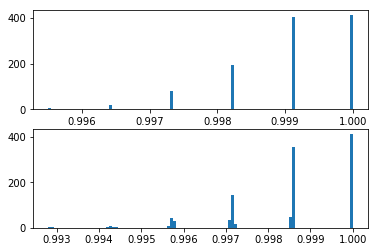

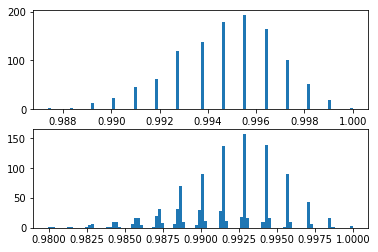

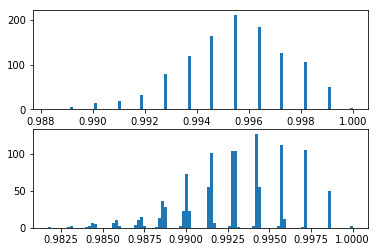

In [43]:
#Building Results
#Sample and replace to check the errors
for j in [fpreds,knnpreds,knnmpreds]:
    res_build = pd.DataFrame({"pred" : j, 'real': vy})
    kappa_build = []
    acc_build = []

    for i in range(len(res_build)):
        np.random.seed = i
        a = resample(res_build)
        acc_build.append(accuracy_score(a["pred"],a["real"]))
        kappa_build.append(cohen_kappa_score(a["pred"],a["real"]))

    
    fig, axs = plt.subplots(2)
    axs[0].hist(acc_build,bins = 100)
    axs[1].hist(kappa_build,bins = 100)
    plt.show
    print("Model:",j)
    print("Acc:",np.mean(acc_build),"±",1.96*st.stdev(acc_build))
    print("Kappa:",np.mean(kappa_build),"±",1.96*st.stdev(kappa_build))


Model [-7494.61012035 -7383.08661621 -7373.5909424  ... -7638.466567
 -7637.86907943 -7637.675861  ]
MAE: 4.698612131718729 ± 0.3471196529344781
r2: 0.9959319115655972 ± 0.0009155414451431658
RMSE: 7.618390375589976 ± 0.8359808333452289
Model [-7535.89751485 -7389.21881857 -7377.3723088  ... -7639.41690507
 -7639.06922491 -7639.4239172 ]
MAE: 4.7030856613438745 ± 0.35372747765596213
r2: 0.9959211604747177 ± 0.0009272643420861246
RMSE: 7.632536001606397 ± 0.8564307783427252
Model [-7535.89751485 -7389.64115231 -7376.92412106 ... -7639.03552339
 -7639.6914442  -7639.28933348]
MAE: 4.687001540563812 ± 0.35411255394605956
r2: 0.9959583042209504 ± 0.000917393810244866
RMSE: 7.588890855783713 ± 0.8362170752352351


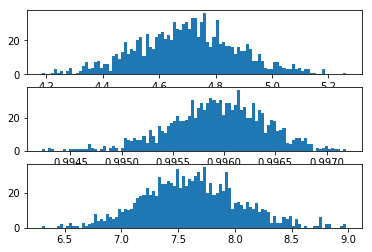

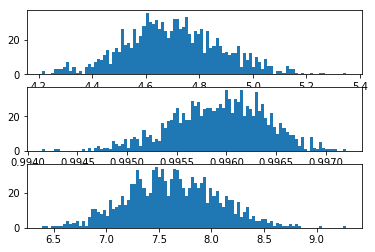

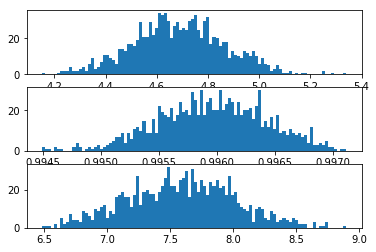

In [44]:
#Longitude Results
for j in [rfpreds1,knnpreds1,knnmpreds1]:
    res_long = pd.DataFrame({"pred" : knnpreds1, 'real': vy1})
    mae_long = []
    r2_long = []
    rmse_long = []
    for i in range(len(res_long)):
        np.random.seed = i
        a = resample(res_long)
        mae_long.append(mean_absolute_error(a["pred"],a["real"]))
        r2_long.append(r2_score(a["pred"],a["real"]))
        rmse_long .append(sqrt(mean_squared_error(a["pred"],a["real"])))
    print("Model",j)    
    print("MAE:",np.mean(mae_long),"±",1.96*st.stdev(mae_long))
    print("r2:",np.mean(r2_long),"±",1.96*st.stdev(r2_long))
    print("RMSE:",np.mean(rmse_long),"±",1.96*st.stdev(rmse_long))
    fig, axs = plt.subplots(3)
    axs[0].hist(mae_long,bins = 100)
    axs[1].hist(r2_long,bins = 100)
    axs[2].hist(rmse_long,bins = 100)
    plt.show

Model [4864883.87723907 4864838.43131549 4864843.46611664 ... 4864907.82924962
 4864909.61326039 4864904.54160841]
MAE: 5.58948360398853 ± 0.43091113335986353
r2: 0.9821444639921124 ± 0.003727992533964195
RMSE: 9.182855480714169 ± 0.8895494252549668
Model [4864910.40957466 4864836.66919339 4864846.9268139  ... 4864911.61392278
 4864912.55768468 4864911.31049165]
MAE: 4.442934308811227 ± 0.34169985319567164
r2: 0.9892752916737696 ± 0.002220513202853052
RMSE: 7.223719724073363 ± 0.7269698678313586
Model [4864910.40957466 4864836.38598182 4864846.95108625 ... 4864909.77736258
 4864913.7210678  4864911.19095031]
MAE: 4.458766994455427 ± 0.34350736094184225
r2: 0.9889574931882003 ± 0.0024030756889809137
RMSE: 7.328324407454816 ± 0.7766287759484553


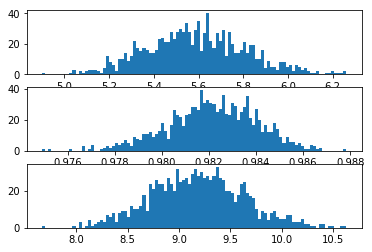

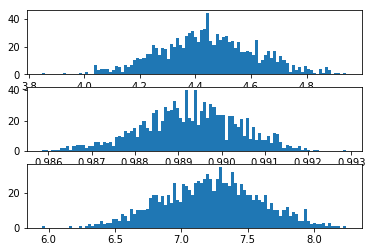

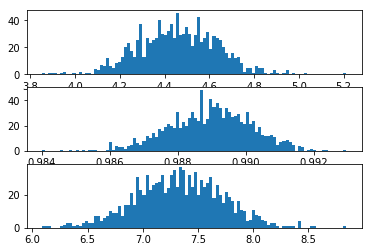

In [45]:
#Latitude Results
for j in [rfpreds2,knnpreds2,knnmpreds2]:
    res_lat = pd.DataFrame({"pred" : j, 'real': vy2})
    mae_lat = []
    r2_lat = []
    rmse_lat = []
    for i in range(len(res_lat)):
        np.random.seed = i
        a = resample(res_lat)
        mae_lat.append(mean_absolute_error(a["pred"],a["real"]))
        r2_lat.append(r2_score(a["pred"],a["real"]))
        rmse_lat .append(sqrt(mean_squared_error(a["pred"],a["real"])))
    
    print("Model",j)  
    print("MAE:",np.mean(mae_lat),"±",1.96*st.stdev(mae_lat))
    print("r2:",np.mean(r2_lat),"±",1.96*st.stdev(r2_lat))
    print("RMSE:",np.mean(rmse_lat),"±",1.96*st.stdev(rmse_lat))

    fig, axs = plt.subplots(3)
    axs[0].hist(mae_lat,bins = 100)
    axs[1].hist(r2_lat,bins = 100)
    axs[2].hist(rmse_lat,bins = 100)
    plt.show

Model [1 4 4 ... 0 0 0]
Acc: 0.9412049215722653 ± 0.013404675117766164
Kappa: 0.9172249042962944 ± 0.018860267098561836
Model [3 4 4 ... 0 0 0]
Acc: 0.9568102624843943 ± 0.01207738269838438
Kappa: 0.9393914706239853 ± 0.01696249709907949
Model [3 4 4 ... 0 0 0]
Acc: 0.9345526811907116 ± 0.014027107187971503
Kappa: 0.9084299968928283 ± 0.01962497274270645


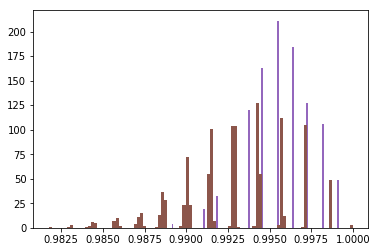

In [46]:
#Floor Results
for j in [rfpreds3,knnpreds3,knnmpreds3]:
    res_floor = pd.DataFrame({"pred" : j, 'real': vy3})
    kappa_floor = []
    acc_floor = []

    for i in range(len(res_floor)):
        np.random.seed = i
        a = resample(res_floor)
        acc_floor.append(accuracy_score(a["pred"],a["real"]))
        kappa_floor.append(cohen_kappa_score(a["pred"],a["real"]))

    print("Model",j)  
    print("Acc:",np.mean(acc_floor),"±",1.96*st.stdev(acc_floor))
    print("Kappa:",np.mean(kappa_floor),"±",1.96*st.stdev(kappa_floor))
    plt.hist(acc_build,bins = 100)
    plt.show
    plt.hist(kappa_build,bins = 100)
    plt.show

In [0]:
predvalidate = validate.copy()
validate["Location"] = validate.index
predvalidate["BUILDINGID"] = fpreds
predvalidate["LONGITUDE"] = knnpreds1
predvalidate["LATITUDE"] = knnpreds2
predvalidate["FLOOR"] = knnpreds3
predvalidate["Location"] = predvalidate.index


# Extra plots


In [50]:
wifi.BUILDINGID = wifi.BUILDINGID.astype('category')
fig = px.scatter_3d(wifi, x = 'LONGITUDE', y = 'LATITUDE', z = 'FLOOR', color = "BUILDINGID")
fig.show()